In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("datamunge/sign-language-mnist")

print("Path to dataset files:", path)

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


In [4]:
downloaded_files = os.listdir(path)
print(downloaded_files)

['american_sign_language.PNG', 'sign_mnist_test.csv', 'sign_mnist_test', 'sign_mnist_train', 'amer_sign2.png', 'amer_sign3.png', 'sign_mnist_train.csv']


In [5]:
data_train = pd.read_csv(path + '/sign_mnist_train.csv')
data_test = pd.read_csv(path + '/sign_mnist_test.csv')

In [6]:
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
data_train.size

21552175

In [8]:
print("Training data shape:", data_train.shape)
print("Test data shape:", data_test.shape)

Training data shape: (27455, 785)
Test data shape: (7172, 785)


In [9]:
# Separate features and labels
training_images = data_train.iloc[:, 1:].values
training_labels = data_train.iloc[:, 0].values

testing_images = data_test.iloc[:, 1:].values
testing_labels = data_test.iloc[:, 0].values

In [10]:
# Reshape and normalize images
training_images = training_images.reshape(-1, 28, 28, 1)
testing_images = testing_images.reshape(-1, 28, 28, 1)

In [11]:
print("Training images shape:", training_images.shape)
print(training_labels.shape)
print("Testing images shape:", testing_images.shape)
print(testing_labels.shape)

Training images shape: (27455, 28, 28, 1)
(27455,)
Testing images shape: (7172, 28, 28, 1)
(7172,)


In [12]:
# Normalize pixel values to range [0, 1]
training_images = training_images / 255.0
testing_images = testing_images / 255.0

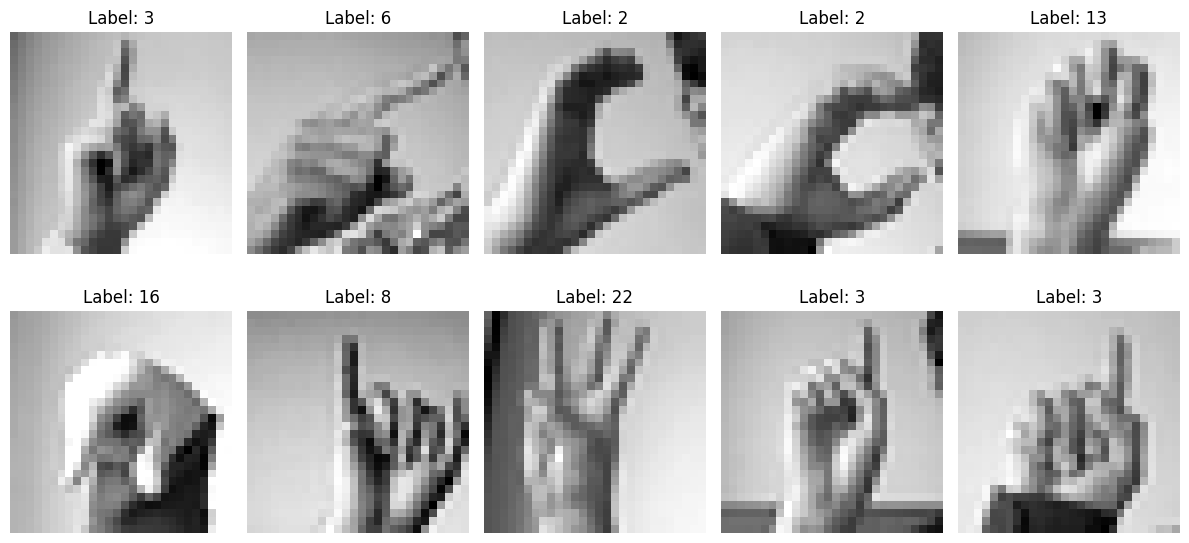

In [13]:
# Visualize sample images
plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(training_images[i].reshape(28,28), cmap='gray')
    plt.title(f'Label: {training_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1.0,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=False
)

In [16]:
# Apply augmentation only to training data
train_generator = train_datagen.flow(training_images, training_labels, batch_size=32)

In [17]:
# Validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0)
validation_generator = validation_datagen.flow(testing_images, testing_labels, batch_size=32)

In [18]:
# Define the CNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(26, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    steps_per_epoch=len(training_images) // 32,
    validation_steps=len(testing_images) // 32
)

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [22]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(testing_images, testing_labels, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

225/225 - 6s - 26ms/step - accuracy: 0.9416 - loss: 0.2214
Test Accuracy: 0.94


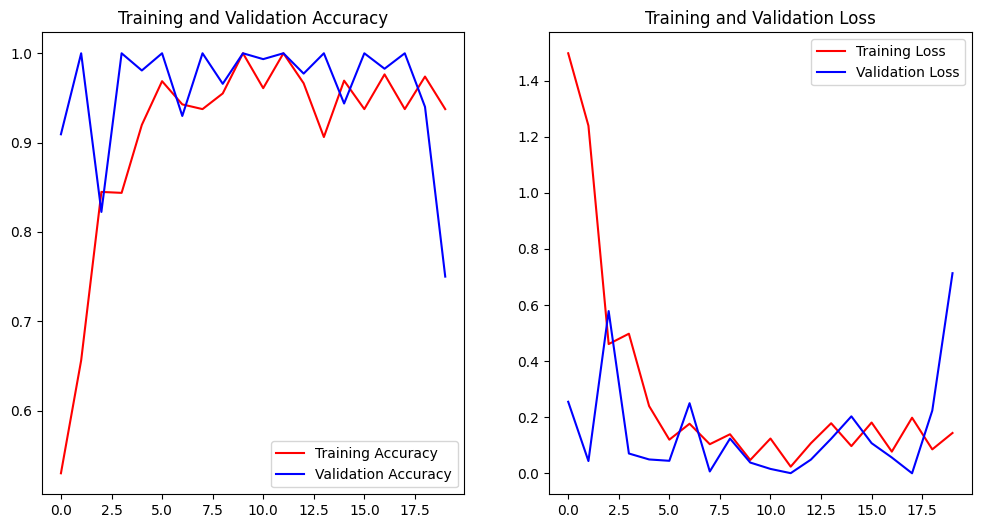

In [23]:
# Plot training and validation accuracy/loss
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [25]:
# Predictions and Evaluation
predictions = model.predict(testing_images)
predicted_labels = np.argmax(predictions, axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


In [26]:
# Classification Report
print("\nClassification Report:")
print(classification_report(testing_labels, predicted_labels))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       331
           1       0.96      1.00      0.98       432
           2       1.00      1.00      1.00       310
           3       1.00      0.97      0.99       245
           4       1.00      0.93      0.96       498
           5       1.00      1.00      1.00       247
           6       0.99      0.99      0.99       348
           7       1.00      0.98      0.99       436
           8       0.96      0.94      0.95       288
          10       0.72      1.00      0.84       331
          11       1.00      0.96      0.98       209
          12       0.95      0.89      0.92       394
          13       0.99      0.96      0.98       291
          14       1.00      1.00      1.00       246
          15       0.86      1.00      0.92       347
          16       1.00      0.81      0.90       164
          17       1.00      0.22      0.36       144
   

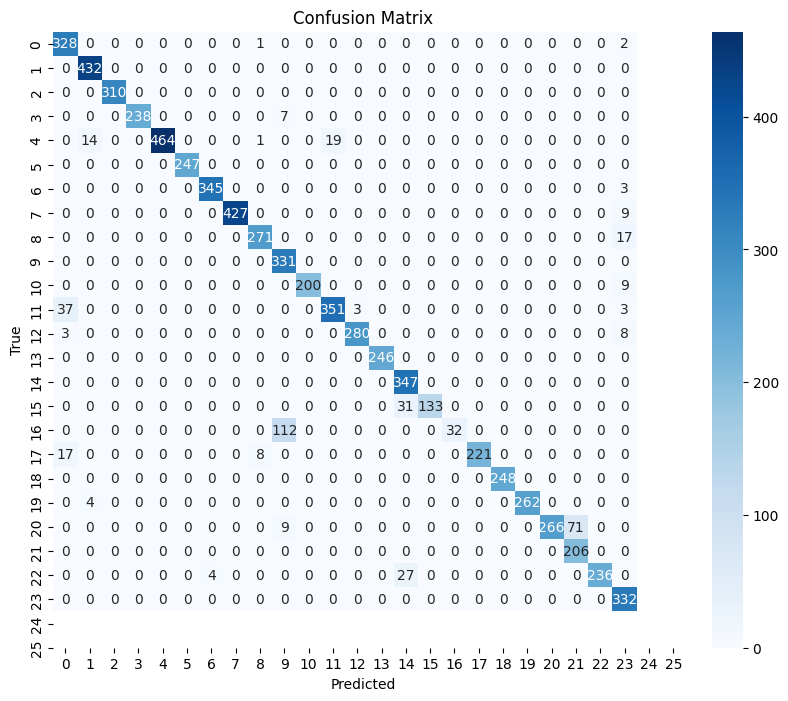

In [29]:
# Confusion Matrix
cm = confusion_matrix(testing_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(26)), yticklabels=list(range(26)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()